<a href="https://colab.research.google.com/github/lanyu0322/pedestrian_firstdraft_figures/blob/master/figure7_restaurants_with_500ft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
# -- install geopandas
try:
  import geopandas as gp
except:
  !pip install geopandas

import pyproj
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#-- read the restaurant data
food_name = os.path.join("drive", "My Drive", "lwir", "data", "food_truck", 
                        "DOHMH_New_York_City_Restaurant_Inspection_Results.csv")
restaurant = pd.read_csv(food_name, parse_dates=["INSPECTION DATE"])

#-- read in the weekday counts
camera_fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                            "cams_ft_wd.feather")
camera = pd.read_feather(camera_fname)

In [ ]:
#-- subset data to available time period
ind = (restaurant["INSPECTION DATE"] >= "2017-01-01") & \
  (restaurant["INSPECTION DATE"] < "2018-01-01") & \
  (restaurant["Latitude"] > 0.0) & \
  (restaurant["Longitude"] < 0.0) & \
  (restaurant["BORO"] == "Manhattan")
restaurant_sub = restaurant[ind]

In [ ]:
#-- camera lat/lon transfer to NYS

def latlon_to_ny(lat, lon):
    """ lat/lon to NYS """

    proj = pyproj.Proj("epsg:2263", preserve_units=True)
    result = proj(lon, lat)

    return result


"""  define helper function """
def npoints(x0, y0, lat, lon, rad):
  
  """ convert lat/lon to NY State Plane """
  ll_nyspd = pyproj.Proj("epsg:2263", preserve_units=True)(lon, lat)

  results = (((ll_nyspd[1] - x0)**2 + (ll_nyspd[0] - y0)**2) <= rad * rad).sum()

  return results

In [ ]:
# -- transfer the datafram to list 

camdat_lat = camera["lat"].to_list()
camdat_lon = camera["lon"].to_list()
lon_mn, lat_mn = latlon_to_ny(camdat_lat, camdat_lon)
camdat_latlon = np.vstack((lat_mn, lon_mn)).T

lat_restaurant = restaurant_sub["Latitude"].to_list()
lon_restaurant = restaurant_sub["Longitude"].to_list()

# -- calculating number of restaurant within 500 feet
restaurant_number = []

# -- set the search radius
rad = 500.

for i in range(len(camera)): 
  size_point = npoints(camdat_latlon[i, 0], camdat_latlon[i, 1], 
                       lat_restaurant, lon_restaurant, rad)
  restaurant_number.append(size_point)

In [ ]:

# --create DataFrame holding the number of restaurant
restaurant_number = pd.DataFrame(restaurant_number)

In [ ]:
# -- write to csv
oname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "restaurant.csv")
restaurant_number.to_csv(oname, index=False)

In [ ]:
len(restaurant_number)

157

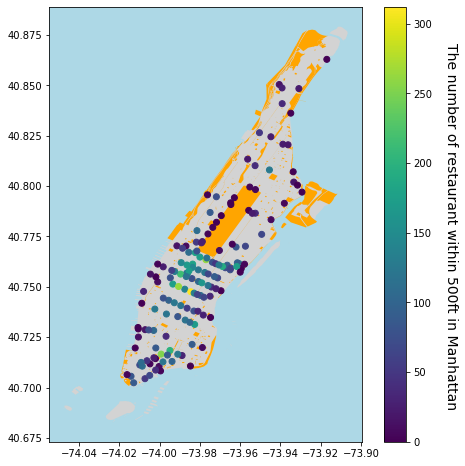

In [ ]:
# -- plot it
#    (Borough geojson from: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm)
bpath = os.path.join("drive", "My Drive", "lwir", "data", "boro_boundaries")
bname = "Borough Boundaries.geojson"
boros = gp.read_file(os.path.join(bpath, bname))
boros = boros[boros.boro_name == "Manhattan"]

# -- set the parks geometries file name
dpath = os.path.join("drive", "My Drive", "lwir", "data", "parks", "properties")
fname = "geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp"

#fig = plt.figure()

# -- load the parks geometries and convert to NY State Plane
parks = gp.read_file(os.path.join(dpath, fname))
parks_m = parks[parks.borough == "M"]

# -- plot it
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor("lightblue")
boros.plot(color="lightgrey", ax=ax, legend=True)
parks_m.plot(color="orange", ax=ax, legend=True)

sc = ax.scatter(camera.lon, camera.lat, c= restaurant_number)
fig.colorbar(mappable=sc, ax=ax)
#plt.title("Enclosed Park Area in Manhattan")

fig.text(0.9, 0.5, "The number of restaurant within 500ft in Manhattan", ha="center", 
         va="center", rotation=-90, fontsize=14)

outfile = os.path.join("drive", "My Drive", "lwir", "output", "figure7", "Enclosed restaurant_number in Manhattan.png")
fig.savefig(outfile)
